# Amazon food review dataset apply SVM

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
Try predicting review using SVM random and grid search and different value of lambda and C

# Import data and libraries
 

In [1]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\suman\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Data preprocessing

In [2]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [3]:
#take only 10000 
#clean_data=sorted_data.sample(frac=1).groupby('Score').head(400)
_ , clean_data = train_test_split(sorted_data, test_size = 10000, random_state=0,stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()
#print(clean_data.shape)

positive    8432
negative    1568
Name: Score, dtype: int64

In [4]:
# Clean html tag and punctuation

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

i=0
str1=' '
mystop={'of','four','one','would'}
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    #change later
    #sent=sent[:20]
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop) & (cleaned_words.lower() not in mystop)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
 
clean_data['CleanedText']=final_string
#store for future use
#conn = sqlite3.connect('clean_data.sqlite')
#c=conn.cursor()
#conn.text_factory = str
#clean_data.to_sql('Reviews1', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
#con = sqlite3.connect('clean_data.sqlite') 
#clean_data = pd.read_sql_query("""SELECT * FROM Reviews1 WHERE Score != 3""", con) 
#clean_data['CleanedText'].sample(15)
print(clean_data.shape)
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data['CleanedText'].sample(2)

(10000, 11)


C:\Users\suman\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


192777    b'realiz look imag onlin didnt even set proper...
183767    b'favorit flavor coffe tea espresso kaldi ive ...
Name: CleanedText, dtype: object

# Split train and test

In [5]:
x=clean_data['CleanedText'].values
y = clean_data['Score']
n=x.shape[0]
n1=int(n*.3)
X_test_raw = x[0:n1]
X_train_raw= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train_raw.shape, X_test_raw.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (7000,) (3000,) (7000,) (3000,)
positive and negative review in train and test
 positive    5939
negative    1061
Name: Score, dtype: int64 
 positive    2493
negative     507
Name: Score, dtype: int64


# Create BOW and try linear kernel SVM

In [6]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train_raw)

#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)
print(X_train.get_shape(),X_test.get_shape())

#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

(7000, 11132) (3000, 11132)


In [7]:
from sklearn.preprocessing import StandardScaler

#Use scale of train and apply to test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

from sklearn.preprocessing import label_binarize

encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y_train=encoded_labels

encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y_test=encoded_labels


print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
#print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (7000, 11132) (3000, 11132) (7000,) (3000,)


C:\Users\suman\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Best parameters with linear karnel and grid search
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix
 Predicted     1   All
Actual               
0           507   507
1          2493  2493
All        3000  3000
Test accuracy using linear kernel 0.831
     C  accuracy_test  accuracy_train  fscore_test  fscore_train gamma  \
0  0.1          0.831        0.848429     0.624343      0.629198  auto   

   kernel             type  
0  linear  Grid search BOW  


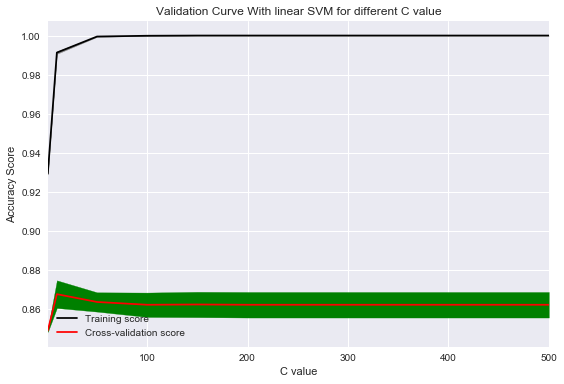

In [8]:
# Build model with linear kernel with random and grid search
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.model_selection import validation_curve
    
   
# Use grid search for L2
C=[.1,1,10,100]
kernel=['linear']
gamma=['auto']

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using GridSearchCV
model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)


print('Best parameters with linear karnel and grid search\n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.best_estimator_.gamma

#print(type(X_train),type(y_train))

#build model with best parameter
model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


aa=pd.DataFrame({'type':['Grid search BOW'],'kernel':['linear'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})


# Check test accuracy
print("Test accuracy using linear kernel",model.score(X_test, y_test))
# Print coefficients
# check no of parameter
#w = model.coef_
#print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))
print(aa)
#Plot accuracy with C
#create plot for training and test validation
# Calculate accuracy on training and test set using range of parameter values
C=[1,10,50,100,150,200,500]
param_range=[1,10,50,100,150,200,500]
train_scores, test_scores = validation_curve(svm.SVC(), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With linear SVM for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(1,500)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


In [9]:
# Try random search
from sklearn.model_selection import RandomizedSearchCV

C=[.1,.5,.8,1,2]
kernel=['linear']
gamma=['auto']

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using random search
model = RandomizedSearchCV(svm.SVC(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

#print(model)

print('Best parameters using linear kernel and random search \n',model.estimator)
#build model with best parameter
optimumc=model.estimator.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.estimator.gamma


model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix \n',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)

bb=pd.DataFrame({'type':['Random Search BOW'],'kernel':['linear'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

print(aa)
# Check test accuracy
print("Test accuracy",model.score(X_test, y_test))



Best parameters using linear kernel and random search 
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix 
 Predicted  0     1   All
Actual                  
0          7   500   507
1          0  2493  2493
All        7  2993  3000
     C  accuracy_test  accuracy_train  fscore_test  fscore_train gamma  \
0  0.1       0.831000        0.848429     0.624343      0.629198  auto   
0  1.0       0.833333        0.932143     0.908859      0.961548  auto   

   kernel               type  
0  linear    Grid search BOW  
0  linear  Random Search BOW  
Test accuracy 0.833333333333


# Apply RBF kernel

Best parameters with rbf karnel and grid search
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix Predicted     1   All
Actual               
0           507   507
1          2493  2493
All        3000  3000
Test accuracy using linear kernel 0.831
Best parameters using rbf kernel and random search 
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Test accuracy 0.833333333333


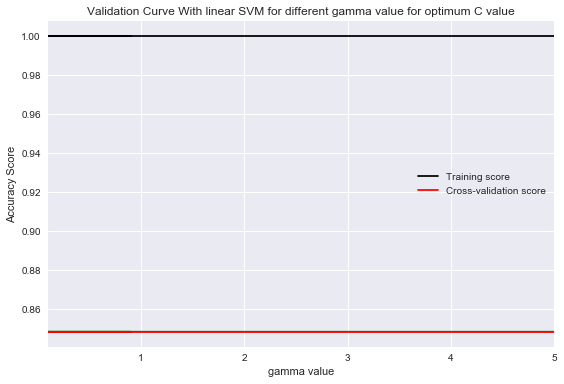

In [10]:
# Build model with linear kernel with random and grid search

import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
    
    
# Use grid search for L2
C=[.1,1,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using GridSearchCV
model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)


print('Best parameters with rbf karnel and grid search\n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.best_estimator_.gamma

#print(type(X_train),type(y_train))

#build model with best parameter
model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['Grid search BOW'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)


# Check test accuracy
print("Test accuracy using linear kernel",model.score(X_test, y_test))
# Print coefficients
# check no of parameter
#w = model.coef_
#print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))


C=[.1,.5,.8,1,2,5]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using random search
model = RandomizedSearchCV(svm.SVC(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

#print(model)

print('Best parameters using rbf kernel and random search \n',model.estimator)
#build model with best parameter
optimumc=model.estimator.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.estimator.gamma


model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

# Check test accuracy
print("Test accuracy",model.score(X_test, y_test))

# plot accuracy with gamma with optimum c
gamma=[.9,.7,.5,.3,.1,1,2,5]
param_range=[.9,.7,.5,.3,.1,1,2,5]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',C=optimumc), X_train, y_train, param_name="gamma", \
                                              param_range=gamma,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With linear SVM for different gamma value for optimum C value")
plt.xlabel("gamma value")
plt.ylabel("Accuracy Score")
plt.xlim(.1,5)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Try with TFIDF

In [11]:
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(X_train_raw)
#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)
print(X_train.get_shape(),X_test.get_shape())
#Use scale of train and apply to test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)

# Build model with linear kernel with random and grid search
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
    
  
# Use grid search for L2
C=[.1,1,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using GridSearchCV
model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)


print('Best parameters with rbf karnel and grid search using TFIDF\n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.best_estimator_.gamma

#print(type(X_train),type(y_train))

#build model with best parameter
model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['Grid search TFIDF'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

# Check test accuracy
print("Test accuracy using linear kernel TFIDF",model.score(X_test, y_test))
# Print coefficients
# check no of parameter
#w = model.coef_
#print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))


C=[.1,.5,.8,1,2,5,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using random search
model = RandomizedSearchCV(svm.SVC(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

#print(model)

print('Best parameters using rbf kernel and random search TFIDF\n',model.estimator)
#build model with best parameter
optimumc=model.estimator.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.estimator.gamma


model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix test\n',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)

bb=pd.DataFrame({'type':['Random search TFIDF'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

# Check test accuracy
print("Test accuracy",model.score(X_test, y_test))



(7000, 11132) (3000, 11132)
size of X_train, X_test, y_train , y_test  (7000, 11132) (3000, 11132) (7000,) (3000,)
Best parameters with rbf karnel and grid search using TFIDF
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix
 Predicted     1   All
Actual               
0           507   507
1          2493  2493
All        3000  3000
Test accuracy using linear kernel TFIDF 0.831
Best parameters using rbf kernel and random search TFIDF
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix test
 Predicted     1   All
Actual               
0           507   507
1          2493  2493
All        3000  3000
Test accura

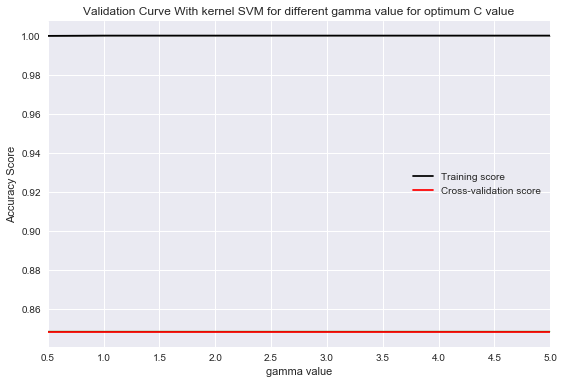

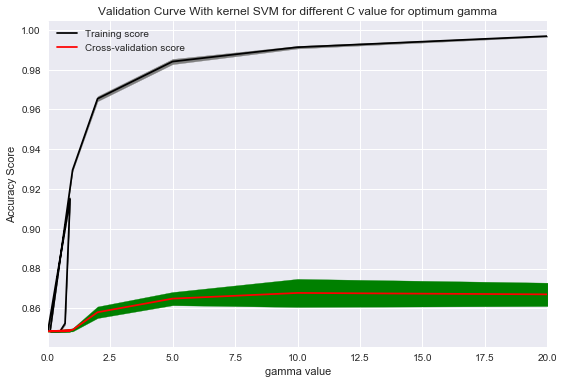

In [12]:
# Plot
# plot accuracy with gamma with optimum c
gamma=[.05,.03,.02,.01,1,2,5]
param_range=[.05,.03,.02,.01,1,2,5]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',C=optimumc), X_train, y_train, param_name="gamma", \
                                              param_range=gamma,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With kernel SVM for different gamma value for optimum C value")
plt.xlabel("gamma value")
plt.ylabel("Accuracy Score")
plt.xlim(.5,5)
plt.tight_layout()
plt.legend(loc="best")
plt.show()

# plot accuracy with C with optimum gamma
C=[.01,.9,.7,.5,.3,.1,1,2,5,10,20]
param_range=[.01,.9,.7,.5,.3,.1,1,2,5,10,20]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',gamma=optimumgamma), X_train, y_train, param_name="C", \
                                              param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With kernel SVM for different C value for optimum gamma")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.01,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


In [13]:
aa

,C,accuracy_test,accuracy_train,fscore_test,fscore_train,gamma,kernel,type
0,0.1,0.831000,0.848429,0.624343,0.629198,auto,linear,Grid search BOW
0,1.0,0.833333,0.932143,0.908859,0.961548,auto,linear,Random Search BOW
0,0.1,0.831000,0.848429,0.624343,0.629198,0.01,rbf,Grid search BOW
0,0.1,0.831000,0.848429,0.624343,0.629198,0.01,rbf,Grid search TFIDF
0,1.0,0.831000,0.932143,0.624343,0.961548,auto,rbf,Random search TFIDF


# AVG W2V

size of X_train, X_test, y_train , y_test  (7000, 50) (3000, 50) (7000,) (3000,)
Best parameters with rbf karnel and grid search using TFIDF
 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix
 Predicted     1   All
Actual               
0           507   507
1          2493  2493
All        3000  3000
Test accuracy using linear kernel AVG W2V 0.831
Best parameters using rbf kernel and random search AVG W2V
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix
 Predicted     1   All
Actual               
0           507   507
1          2493  2493
All        3000  3000
Test accuracy 0.831


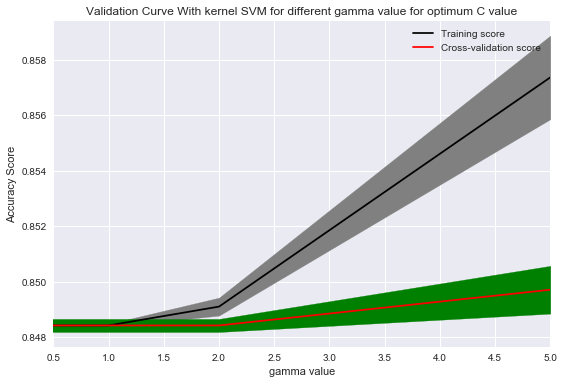

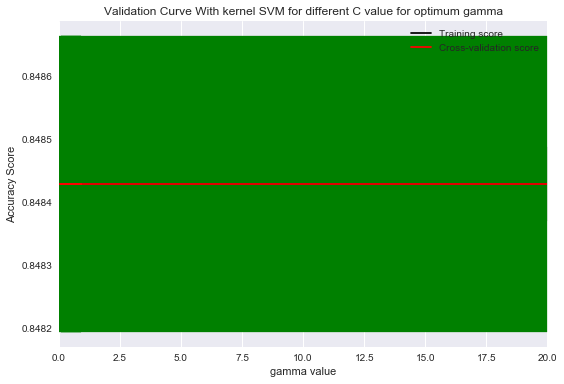

In [14]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
#convert W2V train data
i=0
#create a list of list to be used in W2V 
list_of_sent_train=[]
for sent in X_train_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)  

    
#convert W2V test data
i=0
#create a list of list to be used in W2V 
list_of_sent_test=[]
for sent in X_test_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)  

# try
X_train = pd.DataFrame(sent_vectors_train)
X_test = pd.DataFrame(sent_vectors_test)

print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)

# Build model with linear kernel with random and grid search
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
    
  
# Use grid search
C=[.1,1,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using GridSearchCV
model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)


print('Best parameters with rbf karnel and grid search using TFIDF\n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.best_estimator_.gamma

#print(type(X_train),type(y_train))

#build model with best parameter
model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['Grid search AVG W2V'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

print("Test accuracy using linear kernel AVG W2V",model.score(X_test, y_test))
C=[.1,.5,.8,1,2,5,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using random search
model = RandomizedSearchCV(svm.SVC(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

#print(model)

print('Best parameters using rbf kernel and random search AVG W2V\n',model.estimator)
#build model with best parameter
optimumc=model.estimator.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.estimator.gamma


model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)
bb=pd.DataFrame({'type':['Random search AVG W2V'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

# Check test accuracy
print("Test accuracy",model.score(X_test, y_test))



# Plot
# plot accuracy with gamma with optimum c
gamma=[.05,.03,.02,.01,1,2,5]
param_range=[.05,.03,.02,.01,1,2,5]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',C=optimumc), X_train, y_train, param_name="gamma", \
                                              param_range=gamma,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With kernel SVM for different gamma value for optimum C value")
plt.xlabel("gamma value")
plt.ylabel("Accuracy Score")
plt.xlim(.5,5)
plt.tight_layout()
plt.legend(loc="best")
plt.show()

# plot accuracy with C with optimum gamma
C=[.01,.9,.7,.5,.3,.1,1,2,5,10,20]
param_range=[.01,.9,.7,.5,.3,.1,1,2,5,10,20]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',gamma=optimumgamma), X_train, y_train, param_name="C", \
                                              param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With kernel SVM for different C value for optimum gamma")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.01,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()





# AVG W2V TFIDF

size of X_train, X_test, y_train , y_test  (7000, 50) (3000, 50) (7000,) (3000,)
Best parameters with rbf karnel and grid search using TFIDF
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix
 Predicted     1   All
Actual               
0           507   507
1          2493  2493
All        3000  3000
Test accuracy using linear kernel TFIDF 0.831
Best parameters using rbf kernel and random search TFIDF
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
confusion matrix
 Predicted     1   All
Actual               
0           507   507
1          2493  2493
All        3000  3000
Test accuracy 0.831


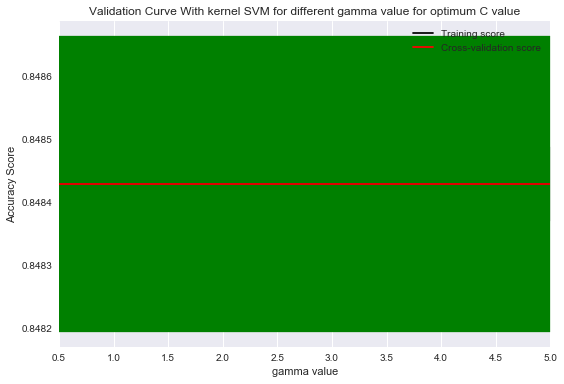

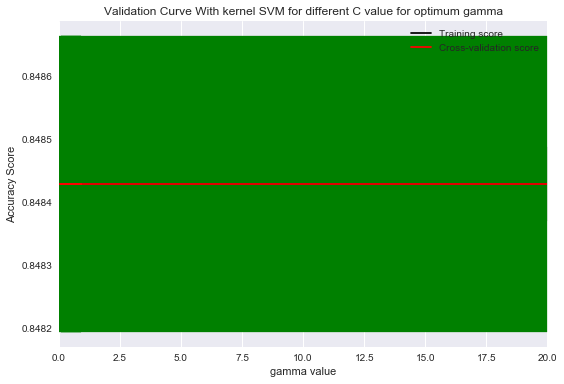

In [15]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(X_train_raw)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
#tfidf_sent_vectors.

# do for test
final_tf_idf=tf_idf_vect.transform(X_test_raw)
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

X_train = pd.DataFrame(tfidf_sent_vectors_train)
X_test = pd.DataFrame(tfidf_sent_vectors_test)
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)


# Build model with linear kernel with random and grid search
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
    
  
# Use grid search for L2
C=[.1,1,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using GridSearchCV
model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)


print('Best parameters with rbf karnel and grid search using TFIDF\n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.best_estimator_.gamma

#print(type(X_train),type(y_train))

#build model with best parameter
model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['Grid search AVG W2V TFIDF'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

# Check test accuracy
print("Test accuracy using linear kernel TFIDF",model.score(X_test, y_test))
# Print coefficients
# check no of parameter
#w = model.coef_
#print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))


C=[.1,.5,.8,1,2,5,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using random search
model = RandomizedSearchCV(svm.SVC(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

#print(model)

print('Best parameters using rbf kernel and random search TFIDF\n',model.estimator)
#build model with best parameter
optimumc=model.estimator.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.estimator.gamma


model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print('confusion matrix\n',mat)
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['Random search AVG W2V TFIDF'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

# Check test accuracy
print("Test accuracy",model.score(X_test, y_test))



# Plot
# plot accuracy with gamma with optimum c
gamma=[.05,.03,.02,.01,1,2,5]
param_range=[.05,.03,.02,.01,1,2,5]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',C=optimumc), X_train, y_train, param_name="gamma", \
                                              param_range=gamma,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With kernel SVM for different gamma value for optimum C value")
plt.xlabel("gamma value")
plt.ylabel("Accuracy Score")
plt.xlim(.5,5)
plt.tight_layout()
plt.legend(loc="best")
plt.show()

# plot accuracy with C with optimum gamma
C=[.01,.9,.7,.5,.3,.1,1,2,5,10,20]
param_range=[.01,.9,.7,.5,.3,.1,1,2,5,10,20]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',gamma=optimumgamma), X_train, y_train, param_name="C", \
                                              param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With kernel SVM for different C value for optimum gamma")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(.01,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()




Second graph x axis name is mentioned wrongly[copy paste error for all graph]. Please consider that. If I execute again it will take 8-9 hrs


# Conclusion
The below steps are taken to complete this
Only !=3 reviews are taken Mark >3 as positive and <3 as negative. Sort data as per product id in ascending order Deduplication of entries for same profilename,userid, time, text and take first element Get stratified sampling of 10k data Clean html and punctuation Convert to uppercase and word<3 are rejected data sorted on time Split the data in train and test to 70:30

BOW
BOW BOW vec created using train data test data is converted using above X is standarize on train and same applied to test y is converted to 1 and 0 from positive and negative 

do grid search and random search for different value of kernel and C best model is established with best hyperparameter. model metric is stored in dataframe and crosstable is printed.Plot cv error with C and penalty

TFIDF 
form tfidf vec using train same is used in test to convert rest are same


AVG W2V 
gensim is used to convert train and test text to 

W2V AVG TFIDF
form tfidf vec using train same is used in test to convert. TFIDF and gensim is used to convert test data. rest are same

The scores are below


In [16]:
aa

,C,accuracy_test,accuracy_train,fscore_test,fscore_train,gamma,kernel,type
0,0.1,0.831000,0.848429,0.624343,0.629198,auto,linear,Grid search BOW
0,1.0,0.833333,0.932143,0.908859,0.961548,auto,linear,Random Search BOW
0,0.1,0.831000,0.848429,0.624343,0.629198,0.01,rbf,Grid search BOW
0,0.1,0.831000,0.848429,0.624343,0.629198,0.01,rbf,Grid search TFIDF
0,1.0,0.831000,0.932143,0.624343,0.961548,auto,rbf,Random search TFIDF
0,10.0,0.831000,0.869143,0.624343,0.928247,1,rbf,Grid search AVG W2V
0,1.0,0.831000,0.848429,0.624343,0.629198,auto,rbf,Random search AVG W2V
0,0.1,0.831000,0.848429,0.624343,0.629198,0.01,rbf,Grid search AVG W2V TFIDF
0,1.0,0.831000,0.848429,0.624343,0.629198,auto,rbf,Random search AVG W2V TFIDF
